<a href="https://colab.research.google.com/github/trista-paul/AB-Demo/blob/master/Unit_4_Week_1_Lending_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
test = pd.read_csv('test_features.csv')
train = pd.read_csv('train_features.csv', nrows= 500000)
y = pd.read_csv('train_labels.csv', nrows= 500000)
sample_submission = pd.read_csv('sample_submission.csv')

In [101]:
print(pipe.predict(test).shape)
submission = sample_submission.copy()
submission['charged_off'] = pipe.predict(test)
submission.head()

(26724,)


,id,charged_off
0,2264704,0
1,1896343,0
2,2077525,0
3,1846827,1
4,1210251,0


In [0]:
submission.to_csv('tristagpaul-lendingclub.csv', index=False)
from google.colab import files
files.download('tristagpaul-lendingclub.csv')

# Run when first opening

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/

!kaggle competitions download -c ds2-tree-ensembles

In [0]:
!unzip train_features.csv.zip
!unzip train_labels.csv.zip
!unzip test_features.csv.zip

In [0]:
!pip install category_encoders
!pip install dtreeviz
!pip install shap

In [0]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from dtreeviz.trees import dtreeviz
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

# Info on original df

In [12]:
train.shape

(500000, 103)

In [13]:
pd.set_option('display.max_columns', 103)
train.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
0,1246716,NaN,22000.0,22000.0,36 months,5.32%,662.53,A,A1,Transition Coordinator,10+ years,MORTGAGE,126000.0,NaN,NaN,home_improvement,Home improvement,604xx,IL,28.99,0.0,Oct-2000,0.0,43.0,NaN,12.0,0.0,9371.0,51%,18.0,w,0.0,29.0,Individual,NaN,NaN,0.0,0.0,367985.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18351.0,NaN,NaN,NaN,2.0,30665.0,3250.0,69.0,0.0,0.0,145.0,182.0,5.0,2.0,2.0,57.0,NaN,18.0,NaN,2.0,3.0,7.0,4.0,4.0,7.0,7.0,9.0,7.0,12.0,NaN,0.0,0.0,2.0,89.0,0.0,0.0,0.0,451899.0,198749.0,9750.0,210298.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
1,1678744,NaN,10000.0,10000.0,36 months,5.32%,301.15,A,A1,Director HQ Controlling,4 years,MORTGAGE,120000.0,NaN,NaN,debt_consolidation,Debt consolidation,019xx,MA,10.69,1.0,Jan-2002,0.0,13.0,NaN,13.0,0.0,9145.0,35%,46.0,w,0.0,NaN,Individual,NaN,NaN,0.0,0.0,40945.0,0.0,9.0,0.0,4.0,13.0,31800.0,66.0,0.0,0.0,5548.0,55.0,26100.0,0.0,1.0,0.0,4.0,3150.0,16355.0,35.9,0.0,0.0,168.0,116.0,31.0,13.0,0.0,31.0,NaN,20.0,13.0,0.0,2.0,2.0,3.0,4.0,41.0,4.0,5.0,2.0,13.0,0.0,0.0,0.0,0.0,97.8,0.0,0.0,0.0,74267.0,40945.0,25500.0,48167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
2,1149018,NaN,7000.0,7000.0,36 months,6.97%,216.05,A,A3,NaN,NaN,RENT,80000.0,NaN,NaN,major_purchase,Major purchase,653xx,MO,29.39,0.0,Jan-2002,2.0,NaN,NaN,13.0,0.0,3703.0,10.4%,20.0,f,0.0,NaN,Individual,NaN,NaN,0.0,0.0,78269.0,1.0,5.0,2.0,3.0,7.0,74566.0,66.0,2.0,3.0,546.0,45.0,35500.0,2.0,0.0,5.0,6.0,6021.0,17930.0,6.1,0.0,0.0,170.0,44.0,4.0,4.0,0.0,4.0,NaN,1.0,NaN,0.0,3.0,6.0,4.0,5.0,10.0,8.0,10.0,6.0,13.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,131514.0,78269.0,19100.0,96014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
3,1349740,NaN,1400.0,1400.0,36 months,13.67%,47.63,C,C4,Administrative Assistant,5 years,RENT,49000.0,NaN,NaN,medical,Medical expenses,770xx,TX,25.07,0.0,Aug-2004,0.0,46.0,NaN,12.0,0.0,19979.0,79.6%,18.0,w,0.0,NaN,Individual,NaN,NaN,0.0,0.0,38644.0,1.0,1.0,1.0,1.0,5.0,18665.0,96.0,0.0,2.0,7612.0,87.0,25100.0,0.0,0.0,0.0,3.0,3220.0,1411.0,93.2,0.0,0.0,111.0,136.0,16.0,5.0,0.0,16.0,NaN,16.0,46.0,0.0,7.0,8.0,7.0,8.0,2.0,11.0,16.0,8.0,12.0,0.0,0.0,0.0,1.0,94.4,100.0,0.0,0.0,44615.0,38644.0,20800.0,19515.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
4,1234365,NaN,19200.0,19200.0,36 months,8.18%,603.26,B,B1,Plant Electrical Engineer,< 1 year,RENT,150000.0,NaN,NaN,credit_card,Credit card refinancing,971xx,OR,16.18,0.0,Oct-1997,3.0,NaN,78.0,8.0,1.0,27000.0,56%,17.0,f,0.0,31

In [14]:
y.head()

,id,charged_off
0,1246716,0
1,1678744,0
2,1149018,1
3,1349740,0
4,1234365,0


In [15]:
train.select_dtypes(exclude=np.number).head()

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,application_type,sec_app_earliest_cr_line,disbursement_method
0,36 months,5.32%,A,A1,Transition Coordinator,10+ years,MORTGAGE,NaN,home_improvement,Home improvement,604xx,IL,Oct-2000,51%,w,Individual,NaN,Cash
1,36 months,5.32%,A,A1,Director HQ Controlling,4 years,MORTGAGE,NaN,debt_consolidation,Debt consolidation,019xx,MA,Jan-2002,35%,w,Individual,NaN,Cash
2,36 months,6.97%,A,A3,NaN,NaN,RENT,NaN,major_purchase,Major purchase,653xx,MO,Jan-2002,10.4%,f,Individual,NaN,Cash
3,36 months,13.67%,C,C4,Administrative Assistant,5 years,RENT,NaN,medical,Medical expenses,770xx,TX,Aug-2004,79.6%,w,Individual,NaN,Cash
4,36 months,8.18%,B,B1,Plant Electrical Engineer,< 1 year,RENT,NaN,credit_card,Credit card refinancing,971xx,OR,Oct-1997,56%,f,Individual,NaN,Cash


In [16]:
train.select_dtypes(exclude=np.number).nunique()

term                             2
int_rate                       626
grade                            7
sub_grade                       35
emp_title                   170190
emp_length                      11
home_ownership                   6
desc                         45666
purpose                         14
title                        26575
zip_code                       912
addr_state                      51
earliest_cr_line               707
revol_util                    1230
initial_list_status              2
application_type                 2
sec_app_earliest_cr_line       491
disbursement_method              2
dtype: int64

In [17]:
train.isnull().sum()

id                                          0
member_id                              500000
loan_amnt                                   0
funded_amnt                                 0
term                                        0
int_rate                                    0
installment                                 0
grade                                       0
sub_grade                                   0
emp_title                               31608
emp_length                              28945
home_ownership                              0
annual_inc                                  0
url                                    500000
desc                                   454027
purpose                                     0
title                                    6262
zip_code                                    1
addr_state                                  0
dti                                       136
delinq_2yrs                                 0
earliest_cr_line                  

# Cleaning Data (First Pass)

In [0]:
def clean(X):
    #drop for good
    X = X.drop(columns=['emp_title', 'desc', 'title', 'grade',
                        'zip_code', 'member_id', 'url', 'id'])
    
    
    #int_rate: convert to float percentage
    #revol_util: convert to float percentage
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    
    #earliest_cr_line: convert to int (year of line)
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'],
                                               infer_datetime_format=True)
    X['earliest_cr_line'] = 2019 - X['earliest_cr_line'].dt.year
    
    
    #emp_length: convert to int (year unit)
    X['emp_length'] = X['emp_length'].str.strip(' years')
    X['emp_length'] = X['emp_length'].str.strip('+ years')
    X['emp_length'] = X['emp_length'].str.strip(' year')
    X['emp_length'] = X['emp_length'].str.strip('<')
    X['emp_length'] = X['emp_length'].replace({np.nan:0})
    X['emp_length'] = X['emp_length'].astype(float)
    
    
    #make flags for high cardinal or high nan features
    #reduce high null features that have many related features
    X['delinq_in_last_2year'] = X['mths_since_last_delinq'] <= 24
    X['record_in_last_2year'] = X['mths_since_last_record'] <= 24
    X['joint'] = X['annual_inc_joint'] == pd.notnull
    X['bankruptcy'] = X['pub_rec_bankruptcies'] == pd.notnull
    X['derogatory_in_last_2year'] = X['mths_since_last_major_derog'] <= 24
    X['il_in_last_2year'] = X['mths_since_rcnt_il'] <= 24
    X['bc_in_last_2year'] = X['mths_since_recent_bc'] <= 24
    X['inq_in_last_2year'] = X['mths_since_recent_inq'] <= 24
    X = X.drop(columns=['sec_app_mths_since_last_major_derog',
                        'sec_app_revol_util',
                        'sec_app_earliest_cr_line',
                        'sec_app_mort_acc',
                        'sec_app_collections_12_mths_ex_med',
                        'sec_app_chargeoff_within_12_mths',
                        'sec_app_num_rev_accts',
                        'sec_app_open_act_il',
                        'sec_app_open_acc',
                        'sec_app_inq_last_6mths',
                        'dti_joint',
                        'revol_bal_joint',
                        'annual_inc_joint',
                        'mths_since_last_record',
                        'mths_since_recent_bc_dlq',
                        'mths_since_last_major_derog',
                        'mths_since_recent_revol_delinq',
                        'mths_since_last_delinq',
                        'mths_since_recent_inq',
                        'mo_sin_old_il_acct',
                        'mths_since_rcnt_il',
                        'il_util',
                        'num_tl_120dpd_2m',
                        'bc_util',
                        'percent_bc_gt_75',
                        'bc_open_to_buy',
                        'mths_since_recent_bc',
                        'all_util',
                        'total_cu_tl',
                        'inq_last_12m',
                        'open_acc_6m',
                        'max_bal_bc',
                        'inq_fi',
                        'open_act_il',
                        'open_il_12m',
                        'open_il_24m',
                        'total_bal_il',
                        'open_rv_12m',
                        'open_rv_24m',
                        'pct_tl_nvr_dlq',
                        'avg_cur_bal',
                        'mo_sin_old_rev_tl_op',
                        'mo_sin_rcnt_rev_tl_op',
                        'num_rev_accts',
                        'tot_hi_cred_lim',
                        'num_actv_rev_tl',
                        'tot_coll_amt',
                        'tot_cur_bal',
                        'mo_sin_rcnt_tl',
                        'total_rev_hi_lim',
                        'num_accts_ever_120_pd',
                        'num_actv_bc_tl',
                        'num_tl_30dpd',
                        'total_il_high_credit_limit',
                        'num_bc_tl',
                        'num_il_tl',
                        'num_op_rev_tl',
                        'num_rev_tl_bal_gt_0',
                        'num_tl_90g_dpd_24m',
                        'num_tl_op_past_12m',
                        'num_sats',
                        'num_bc_sats',
                        'total_bc_limit',
                        'acc_open_past_24mths',
                        'mort_acc',
                        'total_bal_ex_mort',
                        'pub_rec_bankruptcies'])

    #averages for remaining features with nulls
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
            
            
    return X
  
train = clean(train)
test = clean(test)

# Cleaning Data (version 2)

In [0]:
def clean(X):
    #drop for good
    X = X.drop(columns=['desc', 'title', 'grade',
                        'zip_code', 'member_id', 'url', 'id'])
    
    
    #int_rate: convert to float percentage
    #revol_util: convert to float percentage
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    
    #earliest_cr_line: convert to int (year of line)
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'],
                                               infer_datetime_format=True)
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.year
    
    #subgrade: convert to float
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
      
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)
    
    #emp_length: convert to int (year unit)
    X['emp_length'] = X['emp_length'].str.strip(' years')
    X['emp_length'] = X['emp_length'].str.strip('+ years')
    X['emp_length'] = X['emp_length'].str.strip(' year')
    X['emp_length'] = X['emp_length'].str.strip('<')
    X['emp_length'] = X['emp_length'].replace({np.nan:0})
    X['emp_length'] = X['emp_length'].astype(float)
    
    #make features for particular titles
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    #make flags for high cardinal or high nan features
    #reduce high null features that have many related features
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc',
                  'emp_title']

    for col in many_nulls:
        X[col] = X[col] == pd.notnull
    

    #averages for remaining features with nulls
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
            
            
    return X
  
train = clean(train)
test = clean(test)

In [63]:
train.head()

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method,emp_title_teacher,emp_title_manager,emp_title_owner
0,22000.0,22000.0,36 months,5.32,662.53,1.1,False,10.0,MORTGAGE,126000.0,home_improvement,IL,28.99,0.0,2000,0.0,False,False,12.0,0.0,9371.0,51.0,18.0,w,0.0,False,Individual,False,False,0.0,0.0,367985.0,1.047736,2.800415,0.775037,1.744604,False,35915.852704,False,1.417963,3.003952,5538.242747,58.292498,18351.0,1.08873,1.607304,2.306674,2.0,30665.0,False,False,0.0,0.0,False,182.0,5.0,2.0,2.0,False,False,False,False,2.0,3.0,7.0,4.0,4.0,7.0,7.0,9.0,7.0,12.0,False,0.0,0.0,2.0,89.0,False,0.0,0.0,451899.0,198749.0,9750.0,210298.0,False,False,False,False,False,False,False,False,False,False,False,Cash,False,False,False
1,10000.0,10000.0,36 months,5.32,301.15,1.1,False,4.0,MORTGAGE,120000.0,debt_consolidation,MA,10.69,1.0,2002,0.0,False,False,13.0,0.0,9145.0,35.0,46.0,w,0.0,False,Individual,False,False,0.0,0.0,40945.0,0.000000,9.000000,0.000000,4.000000,False,31800.000000,False,0.000000,0.000000,5548.000000,55.000000,26100.0,0.00000,1.000000,0.000000,4.0,3150.0,False,False,0.0,0.0,False,116.0,31.0,13.0,0.0,False,False,False,False,0.0,2.0,2.0,3.0,4.0,41.0,4.0,5.0,2.0,13.0,False,0.0,0.0,0.0,97.8,False,0.0,0.0,74267.0,40945.0,25500.0,48167.0,False,False,False,False,False,False,False,False,False,False,False,Cash,False,False,False
2,7000.0,7000.0,36 months,6.97,216.05,1.3,False,0.0,RENT,80000.0,major_purchase,MO,29.39,0.0,2002,2.0,False,False,13.0,0.0,3703.0,10.4,20.0,f,0.0,False,Individual,False,False,0.0,0.0,78269.0,1.000000,5.000000,2.000000,3.000000,False,74566.000000,False,2.000000,3.000000,546.000000,45.000000,35500.0,2.00000,0.000000,5.000000,6.0,6021.0,False,False,0.0,0.0,False,44.0,4.0,4.0,0.0,False,False,False,False,0.0,3.0,6.0,4.0,5.0,10.0,8.0,10.0,6.0,13.0,False,0.0,0.0,4.0,100.0,False,0.0,0.0,131514.0,78269.0,19100.0,96014.0,False,False,False,False,False,False,False,False,False,False,False,Cash,False,False,False
3,1400.0,1400.0,36 months,13.67,47.63,3.4,False,5.0,RENT,49000.0,medical,TX,25.07,0.0,2004,0.0,False,False,12.0,0.0,19979.0,79.6,18.0,w,0.0,False,Individual,False,False,0.0,0.0,38644.0,1.000000,1.000000,1.000000,1.000000,False,18665.000000,False,0.000000,2.000000,7612.000000,87.000000,25100.0,0.00000,0.000000,0.000000,3.0,3220.0,False,False,0.0,0.0,False,136.0,16.0,5.0,0.0,False,False,False,False,0.0,7.0,8.0,7.0,8.0,2.0,11.0,16.0,8.0,12.0,False,0.0,0.0,1.0,94.4,False,0.0,0.0,44615.0,38644.0,20800.0,19515.0,False,False,False,False,False,False,False,False,False,False,False,Cash,False,

In [64]:
train.shape

(500000, 99)

# Cleaning, Version 3 (columns kept by feature importances)

In [0]:
columns3 = ['loan_amnt',
            'funded_amnt',
            'term',
            'int_rate',
            'installment',
            'sub_grade',
            'emp_length',
            'home_ownership',
            'annual_inc',
            'purpose',
            'addr_state',
            'dti',
            'delinq_2yrs',
            'earliest_cr_line',
            'inq_last_6mths',
            'open_acc',
            'pub_rec',
            'revol_bal',
            'revol_util',
            'total_acc',
            'initial_list_status',
            'tot_coll_amt',
            'tot_cur_bal',
            'open_acc_6m',
            'open_act_il',
            'open_il_12m',
            'open_il_24m',
            'total_bal_il',
            'open_rv_12m',
            'open_rv_24m',
            'max_bal_bc',
            'all_util',
            'total_rev_hi_lim',
            'inq_fi',
            'total_cu_tl',
            'inq_last_12m',
            'acc_open_past_24mths',
            'avg_cur_bal',
            'mo_sin_old_rev_tl_op',
            'mo_sin_rcnt_rev_tl_op',
            'mo_sin_rcnt_tl',
            'mort_acc',
            'num_accts_ever_120_pd',
            'num_actv_bc_tl',
            'num_actv_rev_tl',
            'num_bc_sats',
            'num_bc_tl',
            'num_il_tl',
            'num_op_rev_tl',
            'num_rev_accts',
            'num_rev_tl_bal_gt_0',
            'num_sats',
            'num_tl_30dpd',
            'num_tl_90g_dpd_24m',
            'num_tl_op_past_12m',
            'pct_tl_nvr_dlq',
            'pub_rec_bankruptcies',
            'tot_hi_cred_lim',
            'total_bal_ex_mort',
            'total_bc_limit',
            'total_il_high_credit_limit',
            'emp_title']

In [96]:
def clean(X):
    #kept columns
    X = X[columns3]
    
    
    #int_rate: convert to float percentage
    #revol_util: convert to float percentage
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    
    #earliest_cr_line: convert to int (year of line)
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'],
                                               infer_datetime_format=True)
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.year
    
    #subgrade: convert to float
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
      
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)
    
    #emp_length: convert to int (year unit)
    X['emp_length'] = X['emp_length'].str.strip(' years')
    X['emp_length'] = X['emp_length'].str.strip('+ years')
    X['emp_length'] = X['emp_length'].str.strip(' year')
    X['emp_length'] = X['emp_length'].str.strip('<')
    X['emp_length'] = X['emp_length'].replace({np.nan:0})
    X['emp_length'] = X['emp_length'].astype(float)
    
    #emp title - only make manager
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X = X.drop(columns='emp_title')
    
    #NONE of the high nan features were kept, which I figured...

    #averages for remaining features with nulls
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
            
            
    return X
  
train = clean(train)
test = clean(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [21]:
y['charged_off'].value_counts()

0    400412
1     99588
Name: charged_off, dtype: int64

In [0]:
y = y.drop(columns='id')
baseline_y = y['charged_off'] == 0

In [0]:
y = pd.Series(y['charged_off'])
y = y.ravel()

In [99]:
train.head()

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,emp_title_manager
0,22000.0,22000.0,36 months,5.32,662.53,1.1,10.0,MORTGAGE,126000.0,home_improvement,IL,28.99,0.0,2000,0.0,12.0,0.0,9371.0,51.0,18.0,w,0.0,367985.0,1.047736,2.800415,0.775037,1.744604,35915.852704,1.417963,3.003952,5538.242747,58.292498,18351.0,1.08873,1.607304,2.306674,2.0,30665.0,182.0,5.0,2.0,2.0,2.0,3.0,7.0,4.0,4.0,7.0,7.0,9.0,7.0,12.0,0.0,0.0,2.0,89.0,0.0,451899.0,198749.0,9750.0,210298.0,False
1,10000.0,10000.0,36 months,5.32,301.15,1.1,4.0,MORTGAGE,120000.0,debt_consolidation,MA,10.69,1.0,2002,0.0,13.0,0.0,9145.0,35.0,46.0,w,0.0,40945.0,0.000000,9.000000,0.000000,4.000000,31800.000000,0.000000,0.000000,5548.000000,55.000000,26100.0,0.00000,1.000000,0.000000,4.0,3150.0,116.0,31.0,13.0,0.0,0.0,2.0,2.0,3.0,4.0,41.0,4.0,5.0,2.0,13.0,0.0,0.0,0.0,97.8,0.0,74267.0,40945.0,25500.0,48167.0,False
2,7000.0,7000.0,36 months,6.97,216.05,1.3,0.0,RENT,80000.0,major_purchase,MO,29.39,0.0,2002,2.0,13.0,0.0,3703.0,10.4,20.0,f,0.0,78269.0,1.000000,5.000000,2.000000,3.000000,74566.000000,2.000000,3.000000,546.000000,45.000000,35500.0,2.00000,0.000000,5.000000,6.0,6021.0,44.0,4.0,4.0,0.0,0.0,3.0,6.0,4.0,5.0,10.0,8.0,10.0,6.0,13.0,0.0,0.0,4.0,100.0,0.0,131514.0,78269.0,19100.0,96014.0,False
3,1400.0,1400.0,36 months,13.67,47.63,3.4,5.0,RENT,49000.0,medical,TX,25.07,0.0,2004,0.0,12.0,0.0,19979.0,79.6,18.0,w,0.0,38644.0,1.000000,1.000000,1.000000,1.000000,18665.000000,0.000000,2.000000,7612.000000,87.000000,25100.0,0.00000,0.000000,0.000000,3.0,3220.0,136.0,16.0,5.0,0.0,0.0,7.0,8.0,7.0,8.0,2.0,11.0,16.0,8.0,12.0,0.0,0.0,1.0,94.4,0.0,44615.0,38644.0,20800.0,19515.0,False
4,19200.0,19200.0,36 months,8.18,603.26,2.1,1.0,RENT,150000.0,credit_card,OR,16.18,0.0,1997,3.0,8.0,1.0,27000.0,56.0,17.0,f,13774.0,64780.0,1.047736,2.800415,0.775037,1.744604,35915.852704,1.417963,3.003952,5538.242747,58.292498,48150.0,1.08873,1.607304,2.306674,4.0,8097.0,209.0,6.0,6.0,0.0,0.0,5.0,5.0,11.0,11.0,5.0,5.0,11.0,4.0,8.0,0.0,0.0,1.0,100.0,0.0,105204.0,64780.0,48150.0,56850.0,False


# First Model (Using 'Cleaning Data First Pass')

In [32]:
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    DecisionTreeClassifier(max_depth=2)
)

cross_val_score(pipe, train, y, cv=5, scoring='roc_auc', n_jobs=-1)

array([0.67224356, 0.67479725, 0.67353988, 0.67134044, 0.67685846])

In [33]:
cross_val_score(pipe, train, baseline_y, cv=5, scoring='roc_auc', n_jobs=-1)
#hardly does better than chance...

array([0.67224356, 0.67479725, 0.67353988, 0.67134044, 0.67685846])

In [35]:
pipe.fit(train, y)
tree = pipe.named_steps['decisiontreeclassifier']
encoder = pipe.named_steps['onehotencoder']
feature_names = encoder.transform(train).columns
feature_names[tree.feature_importances_ > 0]

Index(['term_ 60 months', 'sub_grade'], dtype='object')

# Second Model (Random Forests, 'Cleaning Data Version 2')

In [0]:
y = pd.Series(data=y['charged_off'])
y = y.ravel()

In [67]:
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.005, 
        oob_score=True, 
        n_jobs=-1)
)

cross_val_score(pipe, train, y, cv=5, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ........................ , score=0.713428873172159, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ....................... , score=0.7167691469693526, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] ....................... , score=0.7137898296780192, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min remaining:    0.0s


[CV] ....................... , score=0.7108191509938192, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.9min remaining:    0.0s


[CV] ....................... , score=0.7142057303349221, total= 1.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished


array([0.71342887, 0.71676915, 0.71378983, 0.71081915, 0.71420573])

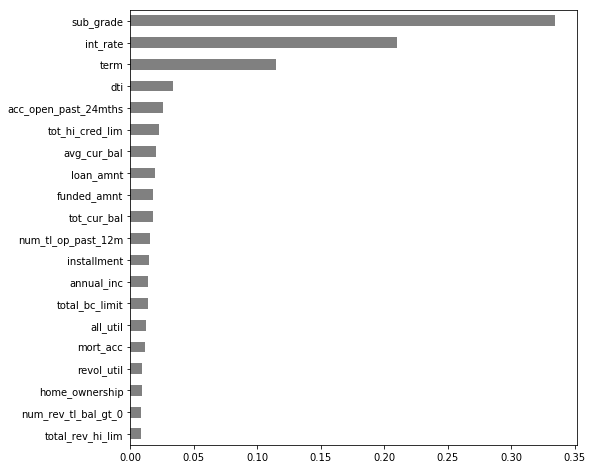

In [68]:
def show_feature_importances(
    pipe, train, y, estimator_name='randomforestclassifier', 
    n=20, figsize=(8, 8)):
    
    # pipe must not change dimensions of X dataframe
    pipe.fit(train, y)
    
    importances = pd.Series(
        pipe.named_steps[estimator_name].feature_importances_, 
        train.columns)

    top_n = importances.sort_values(ascending=False)[:n]
    
    plt.figure(figsize=figsize)
    top_n.sort_values().plot.barh(color='grey')

    
show_feature_importances(pipe, train, y)

# Model 3 (original)

In [0]:
#the original way Version 3 was made
forest = pipe.named_steps['randomforestclassifier']
encoder = pipe.named_steps['ordinalencoder']
feature_names = encoder.transform(train).columns
train2 = train[feature_names[forest.feature_importances_ > 0]]
test2 = test[train2.columns]

In [70]:
test2.shape

(26724, 62)

In [71]:
train2.shape

(500000, 62)

In [73]:
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.005, 
        oob_score=True, 
        n_jobs=-1)
)


pipe.fit(train2,  y)
cross_val_score(pipe, train2, y, cv=5, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.7131226916889472, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ........................ , score=0.715898074981066, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] ....................... , score=0.7139029467383541, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min remaining:    0.0s


[CV] ....................... , score=0.7109168260187573, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.1min remaining:    0.0s


[CV] ....................... , score=0.7150858751564052, total= 1.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.3min finished


array([0.71312269, 0.71589807, 0.71390295, 0.71091683, 0.71508588])

In [74]:
test2.columns.tolist()

['loan_amnt',
 'funded_amnt',
 'term',
 'int_rate',
 'installment',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'total_bal_il',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'pub_rec_bankruptcies',
 'tot_hi_cred_lim',
 'total_bal_ex

# Model 3 (from Clean Version 3)

In [100]:
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.005, 
        oob_score=True, 
        n_jobs=-1)
)

pipe.fit(train,  y)
cross_val_score(pipe, train, y, cv=5, scoring='roc_auc')

array([0.7132646 , 0.71601924, 0.71315515, 0.71040627, 0.71493273])

In [104]:
%%time
y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
print('ROC AUC, Out-of-Bag estimate:', roc_auc_score(y, y_pred_proba))

ROC AUC, Out-of-Bag estimate: 0.7128782296747505
CPU times: user 189 ms, sys: 7.99 ms, total: 197 ms
Wall time: 201 ms
